In [ ]:
"""
Minimal DQN for Milling Environment with Reward Normalization and TensorBoard Logging
---------------------------------------------------------------------------------------
This script implements a minimal DQN applied to our 3D milling environment (no-overhang half-sphere).
The environment simulates:
  - A voxel grid representing stock (True means present, False removed)
  - A protected target shape (a half-sphere anchored on z=0)
  - A router whose moves remove stock along a path; if the path touches the target or goes OOB, the episode ends.

The DQN is trained with a replay buffer, and we log multiple metrics (episode reward, steps, stock removed,
and the loss) to TensorBoard. Reward normalization is performed using an exponential moving average.
"""

import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from torch.utils.tensorboard import SummaryWriter
import datetime
import os
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 1) Environment: Milling3DEnv
# -------------------------------------------------------------------------

class Milling3DEnv:
    def __init__(self, grid_size=8, min_radius=2, max_radius=3, max_steps=50):
        self.grid_size = grid_size
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        """
        1) stock: NxNxN => True means voxel present
        2) shape: NxNxN => half-sphere anchored at z=0
        3) router_pos => (0,0,0)
        4) router_path => list of positions visited
        5) moves_count => how many successful moves before done
        6) total_removed => how many stock voxels were removed in total
        """
        
        n = self.grid_size
        # Initialize stock: all voxels present
        self.stock = np.ones((n, n, n), dtype=bool)
        # Initialize shape: will be a half-sphere anchored at z=0
        self.shape = np.zeros((n, n, n), dtype=bool)

        # Random radius for half-sphere
        r = np.random.randint(self.min_radius, self.max_radius + 1)
        # Choose center (cx,cy) such that shape fits, and set cz=0 (bottom)
        cx = np.random.randint(r, n - r)
        cy = np.random.randint(r, n - r)
        cz = 0
        '''
        for x in range(n):
            for y in range(n):
                for z in range(n):
                    if z >= 0:
                        dx = x - cx
                        dy = y - cy
                        dz = z - cz
                        if dx*dx + dy*dy + dz*dz <= r*r:
                            self.shape[x, y, z] = True

        '''
        # Set initial router position
        self.router_pos = np.array([0, 0, 0], dtype=int)
        self.steps_taken = 0
        self.done = False
        self.total_removed = 0.0
        self.termination_reason = None

        # path of router
        self.router_path = [tuple(self.router_pos)]
        self.moves_count = 0

        return self._get_observation()

    def line_voxels(self, start, end):
        s = start.astype(float)
        e = end.astype(float)
        diff = e - s
        length = int(np.linalg.norm(diff))
        if length == 0:
            return [tuple(start)]
        steps = max(1, length * 2)
        visited = set()
        out = []
        for i in range(steps + 1):
            t = i / steps
            coords = np.round(s + diff * t).astype(int)
            c_tuple = tuple(coords)
            if c_tuple not in visited:
                visited.add(c_tuple)
                out.append(c_tuple)
        return out

    def do_move(self, target):
        if self.done:
            return self._get_observation(), 0.0, True

        path_vox = self.line_voxels(self.router_pos, target)
        failed = False
        reward = 0.0
        reason = None

        amount_removed = 0.0
        for vx, vy, vz in path_vox:
            if not (0 <= vx < self.grid_size and 0 <= vy < self.grid_size and 0 <= vz < self.grid_size):
                failed = True
                reason = "out_of_bounds"
                break
            if self.shape[vx, vy, vz]:
                failed = True
                #reward -= 10
                reason = "shape"
                break
            if self.stock[vx, vy, vz]:
                self.stock[vx, vy, vz] = False
                amount_removed += 1.0
            
        # update reward scaling based on amount removed
        if amount_removed > 0:
            percent_removed = amount_removed / np.sum(self.stock)
            reward += percent_removed * 100.0

        if not failed:
            #reward -= 2 # step cost
            self.router_pos = target.copy()
            self.router_path.append(tuple(self.router_pos))
            self.moves_count += 1
            self.total_removed += amount_removed

        self.steps_taken += 1
        # update reward slightly to incentivize lasting longer
        reward += self.steps_taken / self.max_steps * 0.5

        if self.steps_taken >= self.max_steps and not failed:
            failed = True
            reason = "max_steps"

        # If all outside stock removed, success
        outside_mask = (self.shape == 0)
        if not failed and np.sum(self.stock[outside_mask]) == 0:
            reward += 200.0  # success bonus
            failed = True
            reason = "complete"

        if failed:
            self.done = True
            self.termination_reason = reason

        return self._get_observation(), reward, self.done

    def _get_observation(self):
        # Flatten stock (0/1), shape (0/1), and router coordinates (3 numbers)
        stock_f = self.stock.flatten().astype(np.float32)
        shape_f = self.shape.flatten().astype(np.float32)
        router_f = self.router_pos.astype(np.float32)
        return np.concatenate([stock_f, shape_f, router_f], axis=0)

    def step(self, action):
        # Decode action from [0, grid_size^3-1] to (x,y,z)
        n = self.grid_size
        z = action % n
        y = (action // n) % n
        x = (action // (n * n)) % n
        next_obs, r, done = self.do_move(np.array([x, y, z], dtype=int))
        return next_obs, r, done, {}

    def reset_gym(self):
        return self.reset()

    @property
    def n_actions(self):
        return self.grid_size**3

    def fraction_outside_removed(self):
        outside_mask = (self.shape == 0)
        current_outside = np.sum(self.stock[outside_mask])
        removed = self.total_removed  # since every removed voxel from outside increments total_removed
        total = np.sum(outside_mask)
        return removed / (total + 1e-8)

    def visualize(self, elev=30, azim=45, title="Final State"):
        """
        3D scatter plot:
         - shape & stock => bright blue
         - outside & stock => gray
         - partial alpha
         - black line for path
         - big red dot for final router pos
        Also print out # of moves & total_removed in the console.
        """
        n = self.grid_size
        stock, shape = self.stock, self.shape

        shape_x, shape_y, shape_z = [], [], []
        outside_x, outside_y, outside_z = [], [], []

        for x in range(n):
            for y in range(n):
                for z in range(n):
                    if stock[x,y,z]:
                        if shape[x,y,z]:
                            shape_x.append(x)
                            shape_y.append(y)
                            shape_z.append(z)
                        else:
                            outside_x.append(x)
                            outside_y.append(y)
                            outside_z.append(z)

        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')

        # shape
        ax.scatter(shape_x, shape_y, shape_z, c='blue', alpha=0.4, s=20, marker='o', label='Shape')
        # outside
        ax.scatter(outside_x, outside_y, outside_z, c='gray', alpha=0.2, s=20, marker='o', label='Outside')

        # path => black line
        if len(self.router_path) > 1:
            px = [p[0]+0.5 for p in self.router_path]
            py = [p[1]+0.5 for p in self.router_path]
            pz = [p[2]+0.5 for p in self.router_path]
            ax.plot(px, py, pz, c='black', linewidth=2, label='Path')

        # final router pos => big red dot
        rx, ry, rz = self.router_pos
        ax.scatter(rx+0.5, ry+0.5, rz+0.5, c='red', s=200, alpha=1.0, marker='o', label='Router')

        ax.set_xlim(0,n)
        ax.set_ylim(0,n)
        ax.set_zlim(0,n)
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(title)
        ax.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        # print stats
        print(f"Number of moves made: {self.moves_count}")
        print(f"Total stock voxels removed: {self.total_removed}")


In [13]:
# -------------------------------------------------------------------------
# 2) Reward Normalizer
# -------------------------------------------------------------------------

class RewardNormalizer:
    def __init__(self, momentum=0.99, eps=1e-8):
        self.momentum = momentum
        self.eps = eps
        self.mean = 0.0
        self.var = 1.0
        self.count = 0

    def update(self, r):
        self.mean = self.momentum * self.mean + (1 - self.momentum) * r
        self.var = self.momentum * self.var + (1 - self.momentum) * ((r - self.mean) ** 2)
        self.count += 1

    def normalize(self, r):
        return (r - self.mean) / (np.sqrt(self.var) + self.eps)

# -------------------------------------------------------------------------
# 3) Simple DQN and Replay Buffer
# -------------------------------------------------------------------------

class SimpleDQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next, done = zip(*batch)
        return np.array(s), np.array(a), np.array(r), np.array(s_next), np.array(done)
    def __len__(self):
        return len(self.buffer)

# -------------------------------------------------------------------------
# 4) DQN Training Loop 
# -------------------------------------------------------------------------

def train_dqn(env, num_episodes=200, batch_size=32, gamma=0.99, lr=1e-3,
              epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995, replay_capacity=10000):
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        print("Using GPU for training.")
    else:
        print("Using CPU for training.")

    obs_dim = len(env.reset_gym())
    n_actions = env.n_actions

    dqn = SimpleDQN(obs_dim, n_actions).to(device)
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    replay = ReplayBuffer(capacity=replay_capacity)

    # Initialize reward normalizer
    reward_normalizer = RewardNormalizer(momentum=0.99) # momentum is used to smooth the reward
    reward_normalizer.update(0.0)  # Initialize with zero to avoid division by zero

    # TensorBoard setup
    log_dir = os.path.join("runs", f"dqn_milling_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}")
    writer = SummaryWriter(log_dir=log_dir)

    epsilon = epsilon_start
    global_step = 0
    update_count = 0

    # Counters for termination reasons
    term_counters = {"shape": 0, "out_of_bounds": 0, "max_steps": 0, "complete": 0}

    for ep in range(num_episodes):
        obs = env.reset_gym()
        obs_t = torch.FloatTensor(obs).to(device)
        done = False
        total_reward = 0.0
        steps_this_ep = 0

        while not done:
            global_step += 1
            # Epsilon-greedy selection
            if random.random() < epsilon:
                action = random.randint(0, n_actions - 1)
            else:
                with torch.no_grad():
                    q_vals = dqn(obs_t.unsqueeze(0))
                    action = q_vals.argmax(dim=1).item()

            next_obs, reward, done, _ = env.step(action)
            # Update the reward normalizer and normalize reward
            reward_normalizer.update(reward)
            norm_reward = reward_normalizer.normalize(reward)
            total_reward += reward

            replay.push(obs, action, norm_reward, next_obs, done)

            obs = next_obs
            obs_t = torch.FloatTensor(obs).to(device)
            steps_this_ep += 1

            if len(replay) >= batch_size:
                s_arr, a_arr, r_arr, s_next_arr, d_arr = replay.sample(batch_size)
                s_ten = torch.FloatTensor(s_arr).to(device)
                a_ten = torch.LongTensor(a_arr).to(device)
                r_ten = torch.FloatTensor(r_arr).to(device)
                s_next_ten = torch.FloatTensor(s_next_arr).to(device)
                d_ten = torch.BoolTensor(d_arr).to(device)

                q_vals = dqn(s_ten)
                q_s_a = q_vals.gather(1, a_ten.unsqueeze(1)).squeeze(1)

                with torch.no_grad():
                    q_next = dqn(s_next_ten)
                    max_q_next, _ = torch.max(q_next, dim=1)
                    max_q_next[d_ten] = 0.0
                target = r_ten + gamma * max_q_next

                loss = nn.MSELoss()(q_s_a, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                update_count += 1
                writer.add_scalar("Loss", loss.item(), update_count)

        # End of episode: epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Log additional metrics:
        writer.add_scalar("EpisodeReward", total_reward, ep)
        writer.add_scalar("StepsPerEpisode", steps_this_ep, ep)
        writer.add_scalar("StockRemoved", env.total_removed, ep)
        outside_mask = (env.shape == 0)
        outside_total = np.sum(outside_mask)
        frac_removed = env.total_removed / (outside_total + 1e-8)
        writer.add_scalar("FractionRemoved", frac_removed, ep)

        # Track termination reason
        term_reason = env.termination_reason if env.termination_reason is not None else "max_steps"
        if term_reason in term_counters:
            term_counters[term_reason] += 1
        writer.add_scalar(f"Terminations/{term_reason}", term_counters[term_reason], ep)

        print(f"Episode {ep+1}/{num_episodes}: Reward={total_reward:.2f}, Steps={steps_this_ep}, "
              f"Epsilon={epsilon:.2f}, StockRemoved={env.total_removed:.0f}, FractionRemoved={frac_removed:.3f}, "
              f"Termination={term_reason}")

    writer.close()
    print("Training complete.")
    return dqn

# -------------------------------------------------------------------------
# 5) Testing Routine
# -------------------------------------------------------------------------

def test_dqn(dqn, env, num_tests=100):
    """
    Runs the trained DQN for num_tests episodes using a greedy (epsilon=0) policy,
    and returns the average fraction of outside stock removed (as a percentage)
    and the average number of steps per episode.
    """
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        print("Using GPU for training.")
    else:
        print("Using CPU for training.")
    total_frac = 0.0
    total_steps = 0
    best_performance = 0.0

    for test in range(num_tests):
        obs = env.reset_gym()
        done = False
        steps = 0

        while not done:
            obs_t = torch.FloatTensor(obs).to(device)
            with torch.no_grad():
                q_vals = dqn(obs_t.unsqueeze(0))
                action = q_vals.argmax(dim=1).item()
            obs, reward, done, _ = env.step(action)
            steps += 1

        frac_removed = env.fraction_outside_removed()  # returns fraction (0 to 1)
        best_performance = max(frac_removed, best_performance)
        total_frac += frac_removed
        total_steps += steps

    avg_frac = total_frac / num_tests
    avg_steps = total_steps / num_tests
    print(f"Average fraction of outside stock removed: {avg_frac * 100:.2f}%")
    print(f"Average number of steps per episode: {avg_steps:.2f}")
    print(f"Best performance: {best_performance * 100:.2f}%")
    return avg_frac, avg_steps

def test_dqn_display(dqn, env, num_test=1):
    """
    Runs the trained DQN for num_tests episodes using a greedy (epsilon=0) policy,
    and visualizes the final state of the environment.
    """
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        print("Using GPU for training.")
    else:
        print("Using CPU for training.")
    for test in range(num_test):
        obs = env.reset_gym()
        done = False
        steps = 0

        while not done:
            obs_t = torch.FloatTensor(obs).to(device)
            with torch.no_grad():
                q_vals = dqn(obs_t.unsqueeze(0))
                action = q_vals.argmax(dim=1).item()
            obs, reward, done, _ = env.step(action)
            steps += 1
        
    # Visualize the final state of the environment
    env.visualize(elev=30, azim=45, title="Final State after Testing")
    print(f"Test completed with {steps} steps.")

In [14]:
env = Milling3DEnv(grid_size=8, min_radius=2, max_radius=3, max_steps=100)

trained_dqn = train_dqn(env, num_episodes=100, batch_size=128, gamma=0.1,
            lr=1e-5, epsilon_start=1.0, epsilon_end=0.3, epsilon_decay=0.999995,
            replay_capacity=10000)
# Visualize the final environment
#env.visualize(elev=30, azim=45, title="Final State After Training")
#env.visualize(elev=30, azim=45, title="Router Path", show_path=True)

Using CPU for training.
Episode 1/100: Reward=111.14, Steps=100, Epsilon=1.00, StockRemoved=294, FractionRemoved=0.574, Termination=max_steps
Episode 2/100: Reward=93.75, Steps=100, Epsilon=1.00, StockRemoved=253, FractionRemoved=0.494, Termination=max_steps
Episode 3/100: Reward=97.72, Steps=100, Epsilon=1.00, StockRemoved=263, FractionRemoved=0.514, Termination=max_steps
Episode 4/100: Reward=98.17, Steps=100, Epsilon=1.00, StockRemoved=264, FractionRemoved=0.516, Termination=max_steps
Episode 5/100: Reward=119.41, Steps=100, Epsilon=1.00, StockRemoved=311, FractionRemoved=0.607, Termination=max_steps
Episode 6/100: Reward=101.42, Steps=100, Epsilon=1.00, StockRemoved=272, FractionRemoved=0.531, Termination=max_steps
Episode 7/100: Reward=101.46, Steps=100, Epsilon=1.00, StockRemoved=272, FractionRemoved=0.531, Termination=max_steps
Episode 8/100: Reward=93.78, Steps=100, Epsilon=1.00, StockRemoved=253, FractionRemoved=0.494, Termination=max_steps
Episode 9/100: Reward=104.02, Steps=

Using CPU for training.
Average fraction of outside stock removed: 2.73%
Average number of steps per episode: 100.00
Best performance: 2.73%
Using CPU for training.


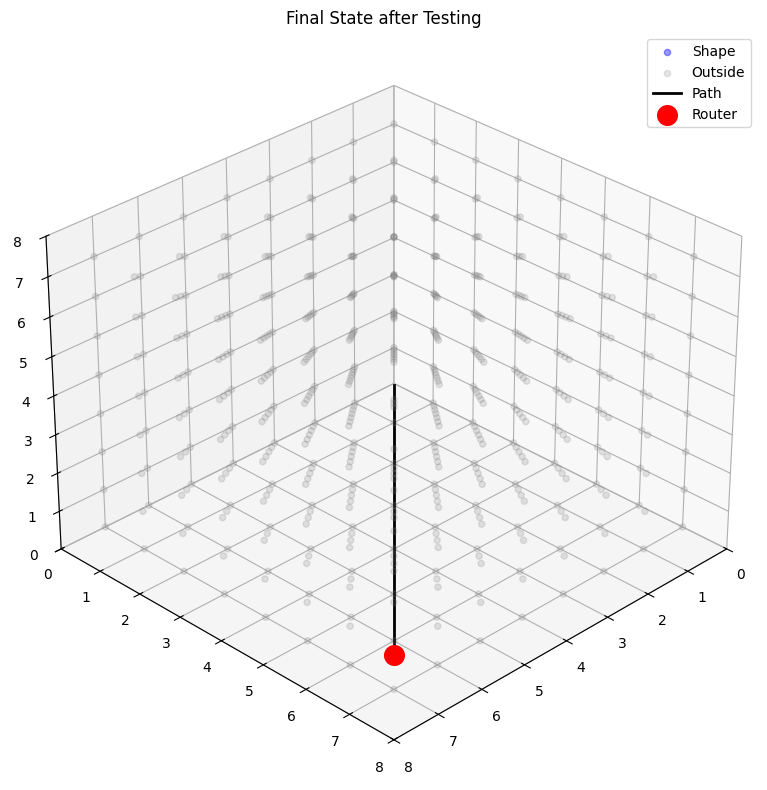

Number of moves made: 100
Total stock voxels removed: 14.0
Test completed with 100 steps.


In [19]:
test_dqn(trained_dqn, env, num_tests=10)
test_dqn_display(trained_dqn, env, num_test=1)

In [16]:
# I would like to test many variations of parameters to see if any make a large difference 

In [17]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
# save model
# torch.save(trained_dqn.state_dict(), "trained_dqn_50K.pth")